In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df1_train = pd.read_parquet('../data/final/2022_data.parquet')
df2_train = pd.read_parquet('../data/final/2023_data.parquet')
df_val = pd.read_parquet('../data/final/2024_data.parquet')
df_train = pd.concat([df1_train, df2_train], ignore_index=True)

In [3]:
categorical = ['date', 'dayofweek', 'away_league', 'home_league', 'park_id']
numerical = ['home_OPS_blend', 'home_FIP_blend', 'home_FPCT_blend', 'away_OPS_blend', 'away_FIP_blend', 'away_FPCT_blend']
target = ['home_won']

In [4]:
vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(df_train[categorical+numerical].to_dict(orient='records'))
all_features = vec.get_feature_names_out()

In [5]:
X_val = vec.transform(df_val[categorical+numerical].to_dict(orient='records'))

In [6]:
y_train = df_train[target].values.ravel()
y_val = df_val[target].values.ravel()

In [7]:
for depth in [1,3,5,7,10]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.523
   3 -> 0.540
   5 -> 0.557
   7 -> 0.529
  10 -> 0.511


In [8]:
for min_samples_leaf in [1,3, 5,10,15]:
    dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (min_samples_leaf, auc))

   1 -> 0.558
   3 -> 0.557
   5 -> 0.556
  10 -> 0.556
  15 -> 0.551


In [9]:
y_pred_train = dt.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_train

0.6348976199648202

In [22]:
# Random Forest

In [14]:
scores = []

for d in [3,5,7,10,15]:
    rf = RandomForestClassifier(n_estimators=200, max_depth=d, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((d, auc))

In [15]:
y_pred_train = rf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_train

0.9992516317688599

In [16]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'auc'])

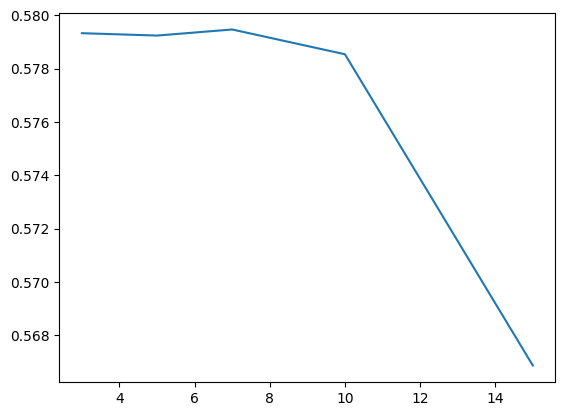

In [17]:
plt.plot(df_scores.max_depth, df_scores.auc)

In [23]:
scores = []

for l in [5,7,10, 15, 20]:
    rf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=l, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((l, auc))

In [24]:
df_scores = pd.DataFrame(scores, columns=['min_sample_leaf', 'auc'])

In [25]:
y_pred_train = rf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_train

0.6312091972858997

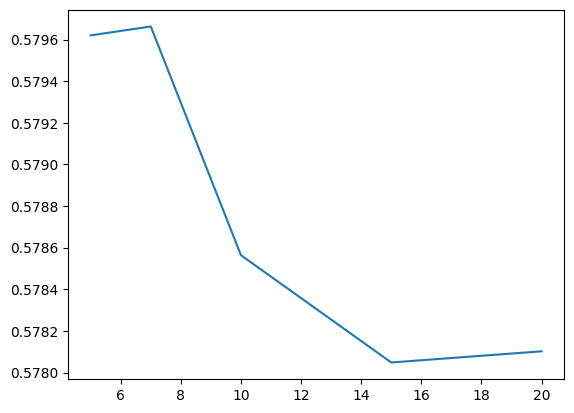

In [26]:
plt.plot(df_scores.min_sample_leaf, df_scores.auc)

In [27]:
rf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=7, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.5796628842577436

# XGBoost

In [28]:
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
import pickle
import random

/workspaces/saber-metrics-machine-learning/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [29]:
search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.15)),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-4), np.log(1.0)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(0.1), np.log(5)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.9, 0.05),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42
    }

In [30]:
score = []
def objective(params):
    xgb_model = xgb.XGBClassifier(early_stopping_rounds=50, **params)
    xgb_model.fit(X_train, y_train,
                 eval_set=[(X_val, y_val)],
                 verbose=False)
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    y_pred = xgb_model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred_proba)
    score.append({'params': params, 'auc': auc})
    
    return {'loss': -auc, 'status': STATUS_OK}

In [31]:
rstate = np.random.default_rng(42)
num_trials = 50
best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

100%|███████████████████████████| 50/50 [00:10<00:00,  4.73trial/s, best loss: -0.5770308655979199]


In [32]:
best_result

{'colsample_bytree': np.float64(0.9),
 'learning_rate': np.float64(0.10292966340743889),
 'max_depth': np.float64(3.0),
 'min_child_weight': np.float64(6.0),
 'n_estimators': np.float64(500.0),
 'reg_alpha': np.float64(0.0027829056195330434),
 'reg_lambda': np.float64(1.083049991904374)}

In [33]:
xgb_score_df = pd.DataFrame(score)

In [34]:
params_df = pd.json_normalize(xgb_score_df['params'])
full_df = pd.concat([xgb_score_df.drop(columns=['params']), params_df], axis=1)

In [35]:
full_df.sort_values(by='auc', ascending=False).head(5)

,auc,colsample_bytree,eval_metric,learning_rate,max_depth,min_child_weight,n_estimators,objective,random_state,reg_alpha,reg_lambda
23,0.577031,0.90,auc,0.102930,3,6.0,500,binary:logistic,42,0.002783,1.083050
26,0.576537,0.85,auc,0.107650,3,1.0,400,binary:logistic,42,0.000884,1.079729
22,0.576166,0.90,auc,0.099821,3,1.0,400,binary:logistic,42,0.000979,1.131349
35,0.575661,0.80,auc,0.034767,3,2.0,400,binary:logistic,42,0.000392,0.434564
29,0.575433,0.70,auc,0.070306,3,3.0,400,binary:logistic,42,0.000470,0.531615


In [36]:
best_result_clean = {
    'max_depth': int(best_result['max_depth']),
    'n_estimators': int(best_result['n_estimators']),
    'min_child_weight': float(best_result['min_child_weight']),
    'colsample_bytree': float(best_result['colsample_bytree']),
    'learning_rate': float(best_result['learning_rate']),
    'reg_alpha': float(best_result['reg_alpha']),
    'reg_lambda': float(best_result['reg_lambda'])
}

In [37]:
score_seed = []
for seed in [random.randint(0, 100) for _ in range(10)]:
    xgb_model = xgb.XGBClassifier(early_stopping_rounds=50, **best_result_clean, seed=seed)
    xgb_model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    y_pred = xgb_model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred_proba)

    y_pred_train = xgb_model.predict_proba(X_train)[:, 1]
    auc_train = roc_auc_score(y_train, y_pred_train)

    print('in sample auc: ', auc_train, '\nout of sample auc: ', auc)
    score_seed.append({'seed': seed, 'auc_train': auc_train, 'auc': auc})

in sample auc:  0.644628360268475 
out of sample auc:  0.5655063596363127
in sample auc:  0.6566737596892114 
out of sample auc:  0.5741077966166164
in sample auc:  0.6534566765112928 
out of sample auc:  0.5716055110055738
in sample auc:  0.6508436722289823 
out of sample auc:  0.5695620456796178
in sample auc:  0.6573901957307342 
out of sample auc:  0.5735443748157587
in sample auc:  0.6575929141791832 
out of sample auc:  0.5730964222206223
in sample auc:  0.6542473379084688 
out of sample auc:  0.5716204540792553
in sample auc:  0.6580989035029612 
out of sample auc:  0.5718452794151009
in sample auc:  0.6558904019311501 
out of sample auc:  0.5703017278268561
in sample auc:  0.6691675685811712 
out of sample auc:  0.5720762178265435


In [38]:
score_seed_df = pd.DataFrame(score_seed)
score_mean = score_seed_df['auc'].mean()
score_std = score_seed_df['auc'].std()
print('mean: ',score_mean, ', std: ', score_std) 

mean:  0.5713266189122257 , std:  0.0024680212506992863


In [39]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('vectorizer', vec),
    ('xgb', xgb_model)
])

In [40]:
filename = 'xgb_pipeline.pkl'
with open(filename, 'wb') as file:
    pickle.dump(pipeline, file)

In [47]:
park_id_df = df_val.groupby('park_id')['home_game_number'].count()
park_id_df.index.to_list()

['ANA01',
 'ARL03',
 'ATL03',
 'BAL12',
 'BIR01',
 'BOS07',
 'CHI11',
 'CHI12',
 'CIN09',
 'CLE08',
 'DEN02',
 'DET05',
 'HOU03',
 'KAN06',
 'LON01',
 'LOS03',
 'MEX02',
 'MIA02',
 'MIL06',
 'MIN04',
 'NYC20',
 'NYC21',
 'OAK01',
 'PHI13',
 'PHO01',
 'PIT08',
 'SAN02',
 'SEA03',
 'SEO01',
 'SFO03',
 'STL10',
 'STP01',
 'TOR02',
 'WAS11',
 'WIL02']

In [48]:
day_df = df_val.groupby('dayofweek')['home_game_number'].count()
day_df.index.to_list()

['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [52]:
df_val.dtypes

date                  int64
dayofweek            object
away_team            object
away_game_number      int64
away_league          object
home_team            object
home_game_number      int64
home_league          object
home_score            int64
away_score            int64
park_id              object
away_P_id            object
home_P_id            object
home_OPS_blend      float64
home_FIP_blend      float64
home_FPCT_blend     float64
away_OPS_blend      float64
away_FIP_blend      float64
away_FPCT_blend     float64
home_won              int64
dtype: object

In [53]:
df_val.head()

,date,dayofweek,away_team,away_game_number,away_league,home_team,home_game_number,home_league,home_score,away_score,park_id,away_P_id,home_P_id,home_OPS_blend,home_FIP_blend,home_FPCT_blend,away_OPS_blend,away_FIP_blend,away_FPCT_blend,home_won
0,20240320,Wed,LAN,1,NL,SDN,1,NL,2,5,SEO01,glast001,darvy001,0.831133,3.886693,0.987413,0.895135,2.774612,0.986950,0
1,20240321,Thu,SDN,2,NL,LAN,2,NL,11,15,SEO01,musgj001,yamay001,0.871884,4.283379,0.988210,0.792875,3.891155,0.983787,0
2,20240328,Thu,COL,1,NL,ARI,1,NL,16,1,PHO01,freek001,gallz001,0.816857,3.796387,0.990063,0.806485,4.997126,0.986123,1
3,20240328,Thu,WAS,1,NL,CIN,1,NL,8,2,CIN09,grayj004,montf001,0.835626,4.195588,0.984061,0.790045,4.133336,0.984583,1
4,20240328,Thu,SLN,1,NL,LAN,3,NL,7,1,LOS03,mikom001,glast001,0.894992,2.767667,0.985197,0.827524,4.072340,0.988514,1
